# Network Traffic Forecasting with AutoTSEstimator

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demostrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to use `AutoTS` in project [Chronos](https://github.com/intel-analytics/bigdl/tree/branch-2.0/python/chronos) to do time series forecasting in an automated and distributed way.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [3]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 2 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 

In [4]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps'
raw_df.AvgRate.str[-4:].unique() 

# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x:float(x[:-4]) if x.endswith("Mbps") else float(x[:-4])*1000)

df["total"] = raw_df["total"]

In [5]:
df.head()

,StartTime,AvgRate,total
0,2018-01-01 00:00:00,306.23,275605455598
1,2018-01-01 02:00:00,285.03,256527692256
2,2018-01-01 04:00:00,247.39,222652190823
3,2018-01-01 06:00:00,211.55,190396029658
4,2018-01-01 08:00:00,234.82,211340468977


In [6]:
df.describe()

,AvgRate,total
count,8760.000000,8.760000e+03
mean,454.070611,4.085273e+11
std,238.371572,2.146467e+11
min,86.490000,8.641890e+09
25%,273.715000,2.460014e+11
50%,410.670000,3.694583e+11
75%,558.200000,5.023054e+11
max,1760.000000,1.585238e+12


Plot the data to see how the KPI's look like

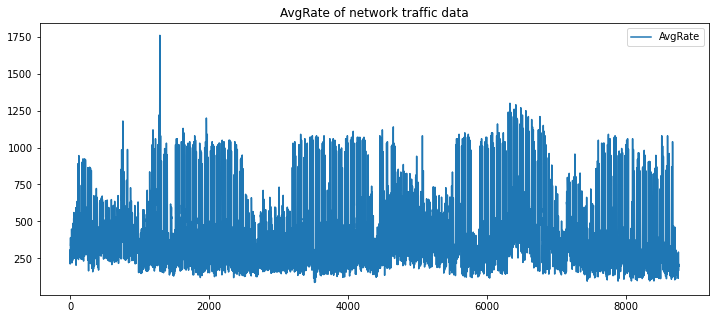

In [7]:
ax = df.plot(y='AvgRate',figsize=(12,5), title="AvgRate of network traffic data")

## Time series forecasting with _AutoTS_

_AutoTS_ provides AutoML support for building end-to-end time series analysis pipelines (including automatic feature generation, model selection and hyperparameter tuning).

The general workflow using automated training contains below two steps. 
   1. create a ```AutoTSEstimator``` to train a ```TSPipeline```, save it to file to use later or elsewhere if you wish.
   2. use ```TSPipeline``` to do prediction, evaluation, and incremental fitting as well. 


Chronos uses [Orca](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca.html) to enable distributed training and AutoML capabilities. Init orca as below. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.


In [8]:
from bigdl.orca import init_orca_context
init_orca_context(cores=10, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/liangs/spark/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/liangs/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.13.0-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-09-09 02:05:06,670	INFO services.py:1174 -- View the Ray dashboard at http://10.239.44.67:8265


{'node_ip_address': '10.239.44.67', 'raylet_ip_address': '10.239.44.67', 'redis_address': '10.239.44.67:6379', 'object_store_address': '/tmp/ray/session_2021-09-09_02-05-06_071746_762/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-09-09_02-05-06_071746_762/sockets/raylet', 'webui_url': '10.239.44.67:8265', 'session_dir': '/tmp/ray/session_2021-09-09_02-05-06_071746_762', 'metrics_export_port': 41602, 'node_id': 'c6d1acec26893328620736d21c7cad919cd87d3ba019a3d66d32fdd5'}


<SparkContext master=local[10] appName=pyspark-shell>

Then we initialize a `AutoTSEstimator`.

In [9]:
from bigdl.chronos.autots import AutoTSEstimator, TSPipeline
import torch
import bigdl.orca.automl.hp as hp
auto_estimator = AutoTSEstimator(model='lstm',
                                 search_space="normal",
                                 past_seq_len=hp.randint(50, 100),
                                 future_seq_len=1,
                                 metric="mse",
                                 cpus_per_trial=2)

We need to split the data frame into train, validation and test data frame before training.

Then we impute the data to handle missing data and scale the data.

You can use [TSDataset](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) as an easy way to finish it.

In [10]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, 
                                                              dt_col="StartTime", 
                                                              target_col="AvgRate", 
                                                              with_split=True, 
                                                              val_ratio=0.1, 
                                                              test_ratio=0.1)
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(one_hot_features=["HOUR", "WEEKDAY"])\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

Then we fit on train data and evaluate on validation data.

In [11]:
%%time
ts_pipeline = auto_estimator.fit(data=tsdata_train,
                   epochs=20,
                   batch_size=128,
                   validation_data=tsdata_val,
                   n_sampling=4)

2021-07-20 21:49:13,129	INFO tune.py:450 -- Total run time: 323.66 seconds (323.60 seconds for the tuning loop).


CPU times: user 30.9 s, sys: 5.12 s, total: 36 s
Wall time: 5min 25s


We get a `TSPipeline` after training. Let's print the hyper paramters selected.
Note that `past_seq_len` is the lookback value that is automatically chosen

In [12]:
best_config = auto_estimator.get_best_config()
best_config

{'hidden_dim': 64,
 'layer_num': 2,
 'lr': 0.0019337279588751044,
 'dropout': 0.13089049120770166,
 'input_feature_num': 7,
 'output_feature_num': 1,
 'past_seq_len': 97,
 'future_seq_len': 1,
 'selected_features': ['HOUR_0',
  'WEEKDAY_4',
  'DAY',
  'WEEKDAY_0',
  'HOUR_10',
  'HOUR_7'],
 'batch_size': 128}

We use tspipeline to predict and evaluate.

In [13]:
y_pred = ts_pipeline.predict(tsdata_test)

plot actual and prediction values for `AvgRate` KPI

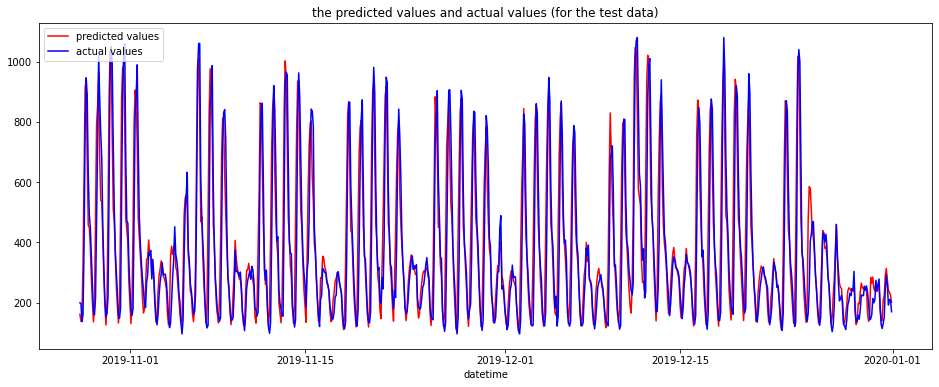

In [14]:
# plot the predicted values and actual values
lookback = best_config['past_seq_len']
plt.figure(figsize=(16,6))
test_df = tsdata_test.unscale().to_pandas()
tsdata_test.scale(standard_scaler, fit=False)
plt.plot(test_df.StartTime[lookback - 1:], y_pred[:,0,0], color='red', label='predicted values')
plt.plot(test_df.StartTime[lookback - 1:], test_df.AvgRate[lookback - 1:], color='blue', label='actual values')
plt.title('the predicted values and actual values (for the test data)')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()

Calculate mean square error and the symetric mean absolute percentage error.

In [15]:
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3167.0167139018245
Evaluate: the smape value is 6.501248516618755


You can save the pipeline to file and reload it to do incremental fitting or others.

In [16]:
# save pipeline file
my_ppl_file_path = "/tmp/saved_pipeline"
ts_pipeline.save(my_ppl_file_path)

You can stop the orca context after auto training.

In [17]:
from bigdl.orca import stop_orca_context
stop_orca_context()

Stopping orca context


Next, we demonstrate how to do incremental fitting with your saved pipeline file.

First load saved pipeline file.

In [18]:
new_ts_pipeline = TSPipeline.load(my_ppl_file_path)

Then do incremental fitting with TSPipeline.fit(). We use validation data frame as additional data for demonstration. You can use your new data frame.

In [19]:
new_ts_pipeline.fit(tsdata_val)

Loss: 0.10407675057649612: 100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


{'mse': 0.066656421048076}

predict and plot the result after incremental fitting.

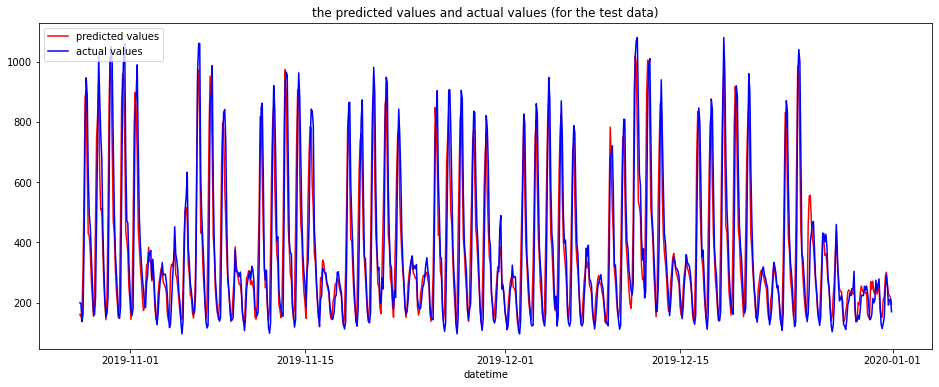

In [20]:
# predict results of test_df
y_pred = new_ts_pipeline.predict(tsdata_test)
lookback = best_config['past_seq_len']
plt.figure(figsize=(16,6))
test_df = tsdata_test.unscale().to_pandas()
tsdata_test.scale(standard_scaler, fit=False)
plt.plot(test_df.StartTime[lookback - 1:], y_pred[:,0,0], color='red', label='predicted values')
plt.plot(test_df.StartTime[lookback - 1:], test_df.AvgRate[lookback - 1:], color='blue', label='actual values')
plt.title('the predicted values and actual values (for the test data)')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()

Calculate mean square error and the symetric mean absolute percentage error.

In [21]:
mse, smape = new_ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3411.7051506539765
Evaluate: the smape value is 6.365709178616939
